# Импорт модулей

In [1]:
!pip install tensorflow==2.12.0

In [2]:
import keras
keras.__version__

'2.12.0'

In [3]:
# Датасет с изображениями
# https://drive.google.com/open?id=1XHDr44w65JHCceXZzTbYX6p3pDfEmLfx

from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Dropout, Reshape, Input, Lambda
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
from os import listdir
import os
import shutil
import PIL
from IPython.display import display
from PIL import Image
import pathlib
import csv
!pip install patool
import patoolib
import base64
import keras.utils as image
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNetV2
from keras.applications.mobilenet import preprocess_input

# Подготовка данных

In [4]:
documentsPath = 'result/s2/'

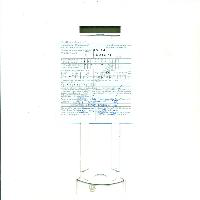

In [5]:
arr = image.load_img(documentsPath + 'mk/100057.jpg')
display(arr)

In [6]:
print('Всего документов: ',  len(listdir(documentsPath + '/document')))
print('Всего договоров: ',  len(listdir(documentsPath + '/mk')))
print('Всего виз: ',  len(listdir(documentsPath + '/visa')))

Всего документов:  2426
Всего договоров:  2528
Всего виз:  1635


In [7]:
coef_train = 0.75
#coef_test = 0.3
documents_value = len(listdir(documentsPath + '/document'))
mk_value = len(listdir(documentsPath + '/mk'))
visa_value =  len(listdir(documentsPath + '/visa'))

In [8]:
print('Документы: ', len(listdir('train/document')),len(listdir('test/document')))

Документы:  1819 607


In [9]:
print('Мк: ', len(listdir('train/mk')),len(listdir('test/mk')))

Мк:  1896 632


In [10]:
print('Виза: ', len(listdir('train/visa')),len(listdir('test/visa')))

Виза:  1226 409


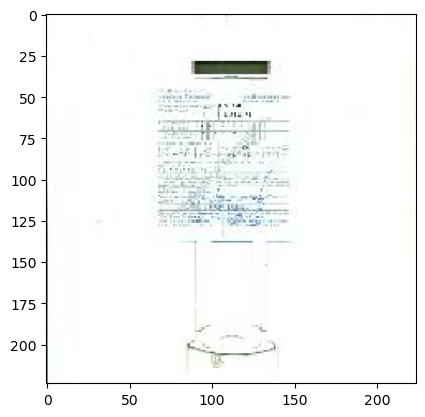

In [11]:
img_path = documentsPath + 'mk/100057.jpg'
img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)
plt.show()

In [12]:
# Размеры изображения
img_width, img_height = 224, 224
# Размерности тензоров
input_shape = (img_width, img_height, 3)
# Размер мини-выборки
batch_size = 32

# Модель без генератора

## Загрузка данных

In [13]:
# Загружаем данные
def data_load(path):
  X = []
  y = []
  class_names = ['document', 'mk', 'visa']
  for class_name in class_names:
    path_temp = os.path.join(path, class_name)
    file_names = listdir(path_temp)
    for file in file_names:
      if 'jpg' in file:
        img = image.load_img(os.path.join(path_temp, file), target_size=(224, 224))
        # convert to numpy array
        img_array = image.img_to_array(img)
        X.append(img_array)
        y.append(class_names.index(class_name))
  return X, y

In [14]:
X_train, y_train = data_load('train')

In [15]:
X_test, y_test = data_load('test')

In [16]:
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

4941 4941
1648 1648


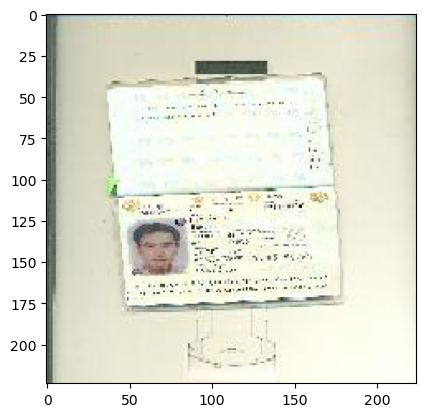

In [17]:
# convert back to image
img_pil = image.array_to_img(X_test[100])
plt.imshow(img_pil)
plt.show()

In [18]:
y_test[100]

0

In [19]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_test
# OHE

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [20]:
X_train = np.asarray(X_train)/255
X_test = np.asarray(X_test)/255
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)
y_test

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

## Строим сеть

In [21]:
from keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50

base_model = ResNet50(weights= 'imagenet', include_top=False, input_shape= input_shape)

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=(Dense(256, activation='relu'))(x)
x = Dropout(0.25)(x)
x=(Dense(64, activation='relu'))(x) #dense layer 2
x = Dropout(0.25)(x)
preds=Dense(3,activation='softmax')(x) #final layer with softmax activation

In [22]:
model=Model(inputs=base_model.input,outputs=preds)

In [23]:
lr = 1e-4
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=lr),
              metrics=['accuracy'])

In [24]:
X_train.shape

(4941, 224, 224, 3)

In [25]:
y_train.shape

(4941, 3)

In [27]:
import time
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy', patience=3)
start_all_time = time.time()
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2, validation_data=(X_test,y_test), callbacks=[early_stopping])
print (f'Обучилась за: {time.time() - start_all_time}')

Epoch 1/50
78/78 [==============================] - 694s 9s/step - loss: 3.0495e-04 - accuracy: 1.0000 - val_loss: 1.4288 - val_accuracy: 0.6596
Epoch 2/50
78/78 [==============================] - 750s 10s/step - loss: 0.0033 - accuracy: 0.9990 - val_loss: 2.4600 - val_accuracy: 0.6402
Epoch 3/50
78/78 [==============================] - 749s 10s/step - loss: 0.0282 - accuracy: 0.9939 - val_loss: 3.0741 - val_accuracy: 0.7008
Epoch 4/50
78/78 [==============================] - 729s 9s/step - loss: 0.0143 - accuracy: 0.9957 - val_loss: 0.9907 - val_accuracy: 0.8246
Epoch 5/50
78/78 [==============================] - 762s 10s/step - loss: 0.0070 - accuracy: 0.9990 - val_loss: 0.7780 - val_accuracy: 0.8507
Epoch 6/50
78/78 [==============================] - 745s 10s/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.4251 - val_accuracy: 0.9169
Epoch 7/50
78/78 [==============================] - 717s 9s/step - loss: 2.9708e-04 - accuracy: 1.0000 - val_loss: 0.1253 - val_accuracy: 0.9678
E

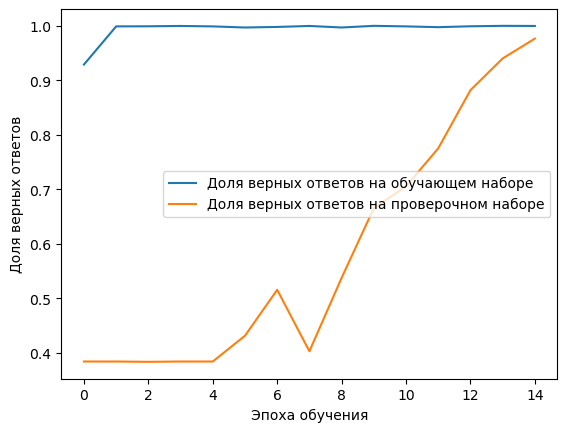

In [29]:
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [30]:
y_predict = model.predict(X_test)

52/52 [==============================] - 54s 1s/step


In [31]:
y_predict = np.argmax(y_predict, axis=1)

In [33]:
model.save('resnet.h5')

In [45]:
# model.save('mobileNet.h5')
model = load_model('resnet.h5')
y_predict = model.predict(X_test)

52/52 [==============================] - 51s 974ms/step


In [46]:
y_test = np.argmax(y_test, axis=1)
y_predict = np.argmax(y_predict, axis=1)
from sklearn.metrics import accuracy_score
print (f'Точность: {accuracy_score(y_predict, y_test)}')

Точность: 0.9763349514563107


In [49]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_predict, average='weighted')

# Выведите результат
print('F1 Score: ', f1)

F1 Score:  0.9762491661133063


In [50]:
from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_test,
                            y_predict, 
                            average='weighted')
precision

0.9765504887983981

In [51]:
recall = recall_score(y_test,
                      y_predict, 
                      average='weighted')
recall

0.9763349514563107